# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from skorch import NeuralNetRegressor
from skorch import NeuralNetClassifier

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


How to load the data:

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

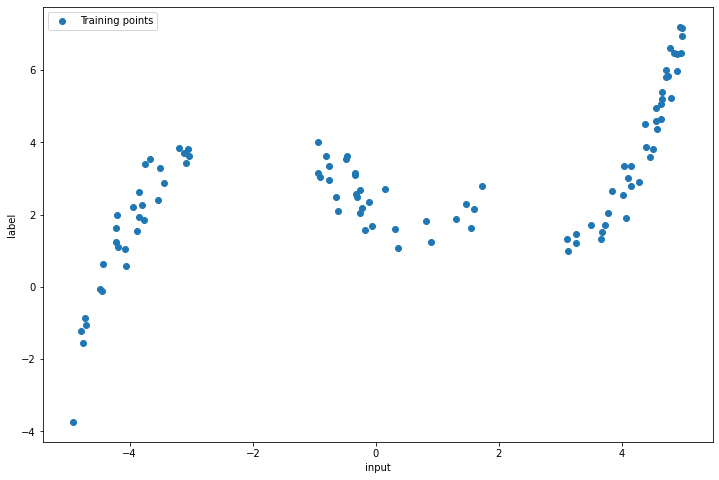

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Network definition

In [7]:
class Net(nn.Module):
    """
    Network with customizable set of hidden layers
    """
    def __init__(self, N_in=1, N_hid=[10], N_out=1, act_func = nn.Sigmoid(), dropout = 0, act_output = False):
        """
        Initialization function for the network
        
        Paramters
        ----------
        
        N_in: Input layer size
        N_out: Output layer size
        N_hid: Array containing sizes of hidden layers
        act_func: Activation function
        dropout: Activate dropout between hidden layers
        
        """
        super(Net,self).__init__()
        
        self.N_in=N_in 
        self.N_hid=N_hid
        self.N_out=N_out
        self.act_func = act_func
        self.dropout = dropout
        self.act_output = act_output
        
        self.hid_layers = []
        self.hid_layers.append(nn.Linear(in_features=N_in, out_features=N_hid[0]))
        for i in range(1,len(N_hid)):
            self.hid_layers.append(nn.Linear(in_features=N_hid[i-1], out_features=N_hid[i]))
            
        self.out_layer = nn.Linear(in_features=N_hid[-1], out_features=N_out)
    
        print('Network initialized')
        
    def forward(self, x):
        for layer in self.hid_layers:
            x = self.act_func(layer(x))
            if self.dropout>0:
                x = nn.Dropout(self.dropout)(x)
  
        x = self.out_layer(x)
        
        if self.act_output == True:
            x = self.act_func(x)
        return x

## Network initialization

In [9]:
torch.manual_seed(0)
N_in = 1
N_hid = [22,102]
N_out = 1
net = Net(N_in, N_hid, N_out,dropout=0.02, act_func=nn.ReLU())

net_skorch = NeuralNetRegressor(
            module=net,
            module__N_in=N_in,
            module__N_hid=N_hid,
            module__N_out=N_out,
            module__dropout=0,
            module__act_func=nn.ReLU(),
            module__act_output=False,
            criterion= nn.MSELoss,
            max_epochs=1000,
            optimizer__lr = 0.28,
            optimizer = optim.Adam,
            criterion__reduction="mean", 
            batch_size = 100,          
            # train validation
#            device='cuda',  # uncomment this to train with CUDA
)

Network initialized


## Observations 
Correct learning rate seems to be found between 1 and 0.01, since it allows to preserve training speed balanced with stability. Also it seems that ReLU works better than a Sigmoid with faster convergence while tanh seems to be comparable. Softmax instead has a worse effect on the overral result.

Adam and SDG with momentum 0.9 seems to get the same result as Adam. Adagrad instead seems not as effective. RMSProp also is very instable and gives a very unstable path to convergence.

L1Loss seems also to improve the result compared to MSELoss with the same learning rate. If we lower it a bit it seems that the convergence is improved a bit.

In general by increasing the number of neurons the result is better, but up to a certain limit ([100,100] seems to be reasonable).

Also the first layer seems not to be fundamental, while the largest effect is associated to the size of the second layer.

Dropout instead has a bad effect on fitting, producing losses over two times the one seen in the best case

Batch sizes must be higher than 10 in order to get a valid result. 100 seems to correspond to a good fit, since it defines the size of the full dataset.

## Dataset initialization

In [10]:
input_data = torch.tensor(train_df["input"].to_numpy().reshape([-1,1]),dtype=torch.float32)
label_data =  torch.tensor(train_df["label"].to_numpy().reshape([-1,1]), dtype=torch.float32)

## Training

In [11]:
net_skorch.fit(input_data, label_data)

Re-initializing module because the following parameters were re-set: N_hid, N_in, N_out, act_func, act_output, dropout.
Network initialized
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.2403       88.7178  0.0623
      2       68.4880       22.1323  0.0030
      3       10.2989        6.5097  0.0048
      4       12.8592       19.6571  0.0040
      5       35.4284       12.1910  0.0030
      6       22.6015        3.9681  0.0061
      7        3.8805       13.1540  0.0040
      8        5.4103       27.0708  0.0040
      9       17.6090       25.9647  0.0040
     10       18.4981       13.1943  0.0040
     11        8.4343        4.0918  0.0029
     12        1.6994        5.6033  0.0053
     13        5.1471       10.5397  0.0041
     14       11.3913       10.0076  0.0040
     15       11.0550        5.2808  0.0039
     16        5.2604        3.4641  0.0035
     17        1.6219        7.3081  0.0040
     18        3.7116   

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (act_func): ReLU()
    (out_layer): Linear(in_features=102, out_features=1, bias=True)
  ),
)

## Losses

In [129]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

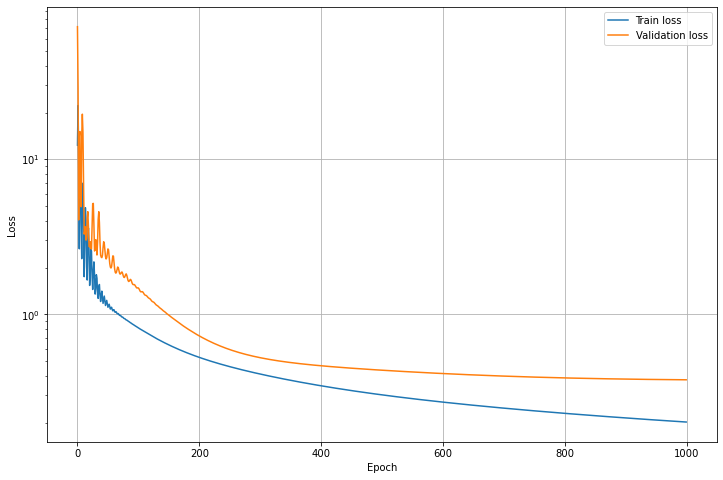

In [130]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Result

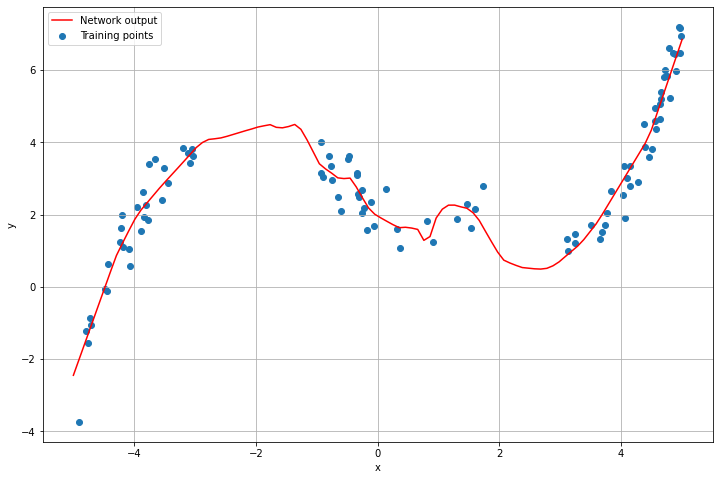

In [131]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = torch.tensor(np.linspace(5,-5,100).reshape(-1,1),dtype=torch.float32)
y_vec = net_skorch.predict(x_vec)

# Plot output
plt.figure(figsize=(12,8))
plt.plot(np.linspace(5,-5,100), y_vec, label='Network output', c = "Red")
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Layer activations

In [132]:
#---Activation profiles---#

#Add a fordard_hook to each layer to record all the activations
acts = []

def activation_hook(module, input, output):
    acts.append(output.detach())

#Add hook to each layer
for layer in net.hid_layers:
    layer.register_forward_hook(activation_hook)

In [133]:
y_test = net(torch.tensor(x_vec).unsqueeze(1))


<ipython-input-133-c432541d63a9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = net(torch.tensor(x_vec).unsqueeze(1))


torch.Size([100, 1, 1])

In [142]:
acts[0].shape

torch.Size([100, 1, 50])

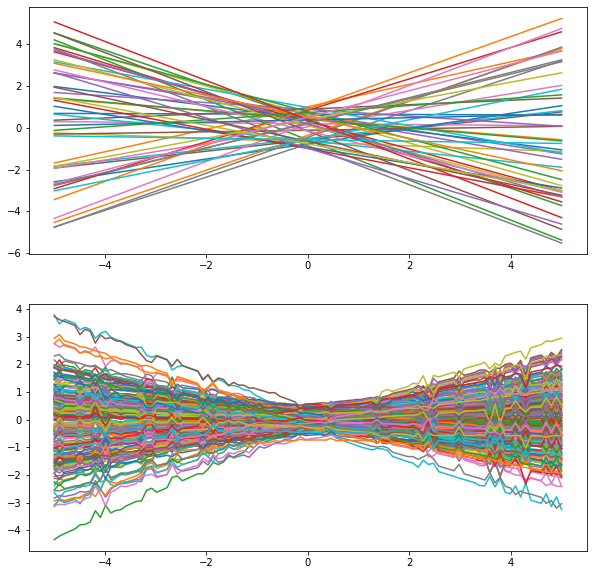

In [152]:
fig, axes = plt.subplots(2,1, figsize = (10,10))
for act,ax in zip(acts,axes.flatten()):
    ax.plot(x_vec,act.reshape(act.shape[0],act.shape[2]))

## Weight visualization

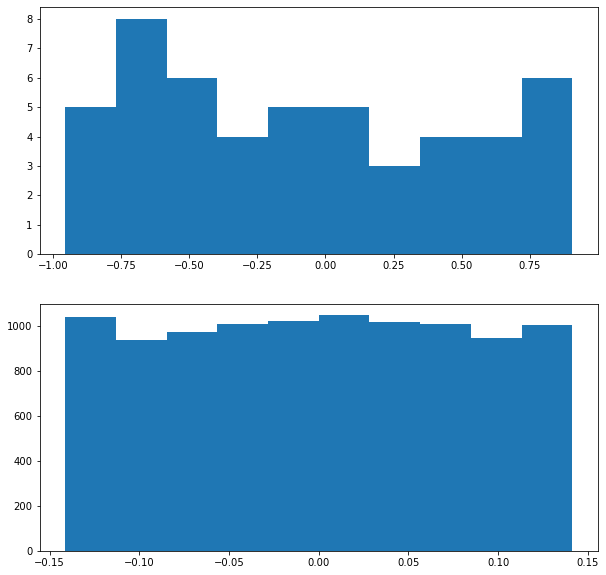

In [158]:
fig, axes = plt.subplots(2,1, figsize = (10,10))
for layer,ax in zip(net.hid_layers,axes.flatten()):
    ax.hist(layer.weight.detach().numpy().flatten())

## GridSearch

In [ ]:
params = {
    'lr': np.arange(0.01,1,0.09),
    'module__N_hid' : [[i,j] for i in np.arange(2,120,20) for j in np.arange(2,120,20)],
}

rs = RandomizedSearchCV(estimator = net_skorch, 
                   param_distributions = params, 
                   cv = 5, n_iter = 100)
rs.fit(input_data, label_data)
print(rs.best_score_, rs.best_params_)

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from torch.nn.functional import one_hot

Download the dataset:

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)
y_train = np.array([y for x, y in iter(train_dataset)])

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


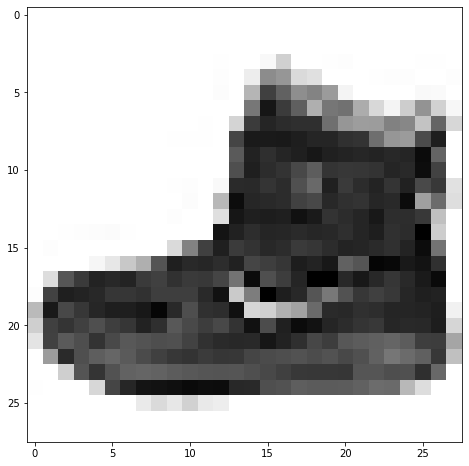

In [4]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [5]:
np.array(image).shape

(28, 28)

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [6]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [7]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## Models definition

In [13]:
class ConvolutionalNet(nn.Module):
    """
    Network with customizable set of hidden layers
    """
    def __init__(self,  dropout=0, act_func=nn.ReLU(), linear_size = 15, conv0_size = 18, conv1_size = 9, kernel_size_pooling=2):
        """
        Initialization function for the network
        
        Parameters
        ----------
        
        N_in: Input layer size
        N_out: Output layer size
        N_hid: Array containing sizes of hidden layers
        act_func: Activation function
        dropout: Activate dropout between hidden layers
        

        (c_out,(h_in+2*padding-dilation*(kernel_size-1)-1)/stride+1,(w_in+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        """
        super(ConvolutionalNet,self).__init__()
        
        self.kernel_size0 = 2
        self.padding0 = 1
        self.stride0 = 2
        self.dilation0 = 1

        self.kernel_size1 = 3
        self.padding1 = 1
        self.stride1 = 2
        self.dilation1 = 1
        
        self.kernel_size_pooling = kernel_size_pooling
        
        self.linear_size = linear_size
        self.conv0_size = conv0_size
        self.conv1_size = conv1_size     
        self.act_func = act_func
        self.final_func = nn.Softmax(dim=1)
        self.N_out= 10
        self.dropout = dropout
        self.dropout_func = nn.Dropout(self.dropout)

        self.conv0 = nn.Conv2d(1,self.conv0_size,kernel_size=self.kernel_size0,padding=self.padding0,stride=self.stride0,dilation=self.dilation0) #(1,28,28) -> (self.conv0_size,15,15)
        
        self.conv1 = nn.Conv2d(self.conv0_size,self.conv1_size,kernel_size=self.kernel_size1,padding=self.padding1,stride=self.stride1,dilation=self.dilation1) #(self.conv0_size,15,15) -> (self.conv1_size,8,8)

        self.max_pool = nn.MaxPool2d(kernel_size=self.kernel_size_pooling) #(self.conv1_size,8,8)->(self.conv1_size,4,4)

        self.lin_layer = nn.Linear(in_features=self.conv1_size*4*4, out_features=self.linear_size)          
        self.out_layer = nn.Linear(in_features=self.linear_size, out_features=self.N_out)
        
        print('Network initialized')
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.act_func(x)
                
        x = self.conv1(x)
        x = self.act_func(x)
        
        x = self.max_pool(x)
        
        x = self.dropout_func(x)

        x = x.view(-1,self.conv1_size*4*4)
        x = self.lin_layer(x)
        x = self.act_func(x)
        
        x = self.out_layer(x)
        
        x = self.final_func(x)
        return x

## Model implementation

In [14]:
torch.manual_seed(0)
classifierNet = ConvolutionalNet()

net_skorch = NeuralNetClassifier(
            module=classifierNet,
            module__act_func=nn.ReLU(),
            criterion= nn.CrossEntropyLoss,
            max_epochs=50,
            optimizer__lr = 1e-3,
            module__linear_size=16,
            optimizer = optim.Adam,
            batch_size = 1000,          
            # train validation
#            device='cuda',  # uncomment this to train with CUDA
)

Network initialized


## Notes

A kernel dilation is negleted since it would reduce consistently the output size. Linear layer size also seems to return good results if it corresponds to the current convolutional layer size. Padding 1 has been observed to be the best value for the first layer. With some values the learning seems to be stuck. Also large values of kernel size seems to be very inefficient during training.

Max Pooling doesn't seems to help much. Up to now the best architecture is built as two convolutional layer and a linear one

## Dataset instantiation

In [10]:
input_data = train_dataset.train_data.type(torch.float32).reshape(60000,1,28,28)
label_data = train_dataset.train_labels.type(torch.int64).reshape(60000)

C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Gridsearch

In [11]:
params = {
    'lr': np.arange(0.01,1,0.09),
    'module__N_hid' : [[i,j] for i in np.arange(2,120,10) for j in np.arange(2,120,10)],
}

rs = RandomizedSearchCV(estimator = net_skorch, 
                   param_distributions = params, 
                   cv = 5, n_iter = 500)
rs.fit(input_data, label_data)
print(rs.best_score_, rs.best_params_)

Re-initializing module because the following parameters were re-set: N_hid, act_func, linear_size.


TypeError: __init__() got an unexpected keyword argument 'N_hid'

In [ ]:
joblib.dump(rs, 'conv.pkl')

## Model fitting

In [15]:
net_skorch.fit(input_data,label_data)

Re-initializing module because the following parameters were re-set: act_func, linear_size.
Network initialized
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0822       0.5010        1.9603  8.8994
      2        1.9524       0.5189        1.9410  9.1182
      3        1.9398       0.5282        1.9319  8.7347
      4        1.9311       0.5348        1.9254  8.6818
      5        1.8970       0.6280        1.8330  9.2560
      6        1.8179       0.6448        1.8139  8.9899
      7        1.8061       0.6552        1.8048  9.1542
      8        1.8005       0.6561        1.8028  9.1127
      9        1.7952       0.6594        1.8004  9.3414
     10        1.7916       0.6651        1.7950  9.2994
     11        1.7886       0.6802        1.7804  9.0238
     12        1.7386       0.7511        1.7107  9.0518
     13        1.7039       0.7596        1.7022  8.8196
     14        1.6963       0.760

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvolutionalNet(
    (act_func): ReLU()
    (final_func): Softmax(dim=1)
    (dropout_func): Dropout(p=0, inplace=False)
    (conv0): Conv2d(1, 18, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv1): Conv2d(18, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lin_layer): Linear(in_features=144, out_features=16, bias=True)
    (out_layer): Linear(in_features=16, out_features=10, bias=True)
  ),
)

## Data losses

In [19]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

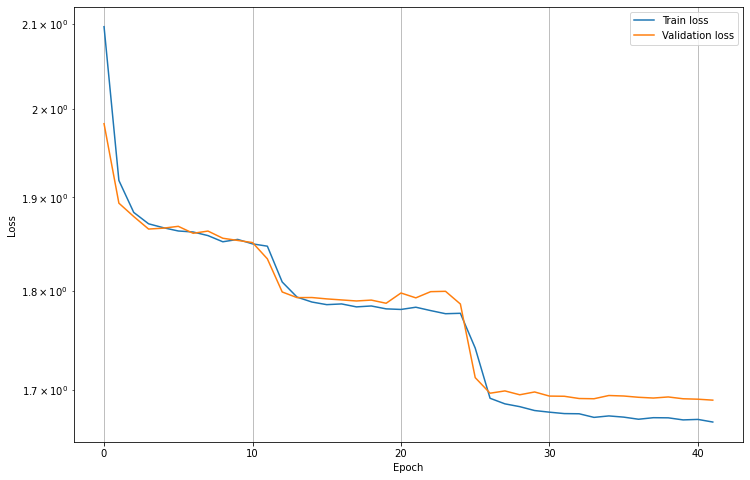

In [20]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Confusion Matrix

In [21]:
y_pred = net_skorch.predict(input_data)

<ipython-input-22-12757266213a>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sn.heatmap(c_matrix/c_matrix.astype(np.float).sum(axis=1) ,annot=True)


<AxesSubplot:>

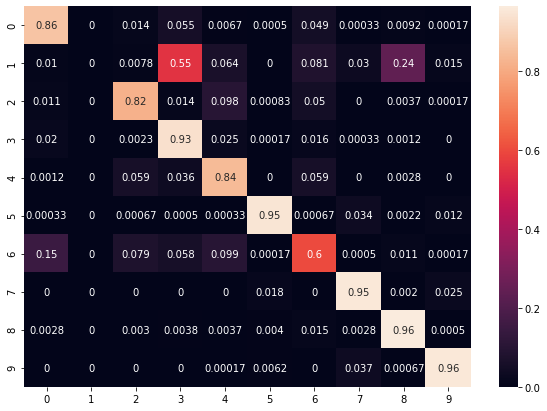

In [22]:
import seaborn as sn
plt.figure(figsize = (10,7))
c_matrix = confusion_matrix(label_data.detach().numpy(),y_pred)
sn.heatmap(c_matrix/c_matrix.astype(np.float).sum(axis=1) ,annot=True)